In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('../')

In [2]:
from Modules.scraping import *
from Modules.supportFunctions import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
data = cut_down(scrap_covid_data())

# START scraping
### Requesting url nr 1
### Requesting url nr 2
### Requesting url nr 3
# END scraping


ValueError: invalid literal for int() with base 10: ''

In [ ]:
def find_timepoint_zero(df):
    df["Timepoint"] = -1

    point_zero = df.loc[df['Infected']>0, "Date"][0]
    df.loc[df['Date'] == point_zero, "Timepoint"] = 0

    previous = -1
    for i, row in df.iterrows():
        if i == point_zero or previous != -1:
            previous = previous + 1
            df.at[i,'Timepoint'] = previous
            
    return df

Text(0,0.5,'New_Infections')

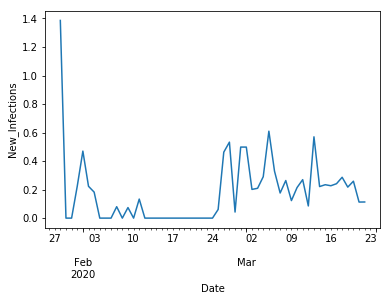

In [51]:
# Get German data
DE = country_filter(data, Country='Germany')
DE = find_timepoint_zero(DE)
DE = DE[DE.Timepoint != -1]

In [46]:
fig, ax = plt.subplots()
DE.loc[:,'Infected'].diff().iloc[1:].plot()
ax.set_ylabel('New_Infections')

In [104]:
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
print('AdFuller:',adfuller(np.log(DE.loc[:,'Infected']).diff()[6:-5])[1])
print('KPSS:',kpss(np.log(DE.loc[:,'Infected']).diff()[6:-5])[1])

AdFuller: 0.18759193606262908
KPSS: 0.1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [108]:
from pyramid.arima import auto_arima
stepwise_model = auto_arima(np.log(DE.loc[:,'Infected'])[5:], start_p=1, start_q=0,
                           max_p=1, max_q=0, m=1,
                           start_P=0, seasonal=False,
                           d=1, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 0); AIC=0.020, BIC=6.042, Fit time=0.055 seconds
Fit ARIMA: order=(0, 1, 0); AIC=1.782, BIC=5.797, Fit time=0.010 seconds
Total fit time: 0.065 seconds
0.019937202235411178


[ 9.34475528  9.54605396  9.74376928  9.9402405  10.13627981]


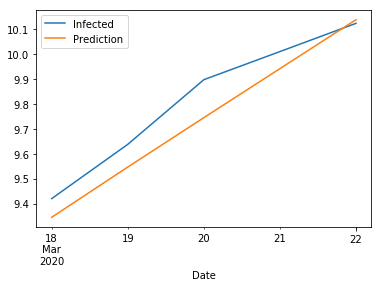

In [141]:
train = pd.Series(np.log(DE.loc[:,'Infected'])[5:-3])
test = pd.Series(np.log(DE.loc[:,'Infected'])[-3:])
stepwise_model.fit(train)
future_forecast = stepwise_model.predict(n_periods=5)
print(future_forecast)
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
pd.concat([test,future_forecast],axis=1).plot()

In [139]:
CH = country_filter(data, Country='China')

Text(0,0.5,'New_Infections')

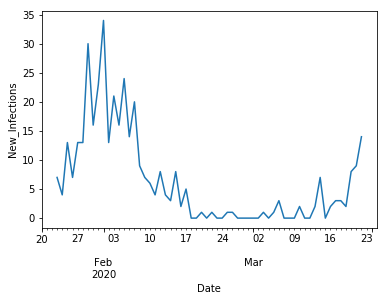

In [145]:
STATES_CH = CH['Province/State'].drop_duplicates()
fig, ax = plt.subplots()
CH.loc[CH['Province/State']=='Shanghai','Infected'].diff().iloc[1:].plot()
ax.set_ylabel('New_Infections')